<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lvm/conv_vae_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder using 2d convolutional encoder/decoder


Code uses TF 2.0 idioms and should work with images of any size and number of channels. Code is based on various sources, including
- https://www.tensorflow.org/beta/tutorials/generative/cvae.
-https://github.com/davidADSP/GDL_code/blob/master/03_01_autoencoder_train.ipynb
etc


## Import TensorFlow and other libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## Load the dataset


In [54]:
#dataname = 'mnist' 
#dataname = 'fashion_mnist'
dataname = 'cifar10' # https://www.tensorflow.org/datasets/catalog/cifar10

# Useful pre-processing functions
#https://github.com/google/compare_gan/blob/master/compare_gan/datasets.py
  
datasets, datasets_info = tfds.load(name=dataname, with_info=True, as_supervised=False)
print(datasets_info)

input_shape = datasets_info.features['image'].shape
print(input_shape)
num_colors = input_shape[2]

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    version=1.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

(32, 32, 3)


In [0]:
batchsize = 64
# We assume the dataset has a dict of features called image and label.
# We extract the image from the dict, and scale each channel to [0,1]
# We return a tuple (rescaled-image, label).

def preprocess_image(sample):
  img = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  label = sample['label']
  return img, label

  
def preprocess_celeba(features):
    """Returns 64x64x3 image and constant label."""
    image = features["image"]
    image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
    # Note: possibly consider using NumPy's imresize(image, (64, 64))
    image = tf.image.resize_images(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.constant(0, dtype=tf.int32)
    return image, label
    

train_dataset = (datasets['train']
                 .map(preprocess_image)
                 .batch(batchsize)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
test_dataset = (datasets['test']
                .map(preprocess_image)
                .batch(batchsize)
                .prefetch(tf.data.experimental.AUTOTUNE))


  

In [56]:
# Inspect the dataset we just created
i = 0
for batch in train_dataset:
  #print(batch)
  X, y = batch
  print(X.shape)
  print(y.shape)
  i += 1
  if i > 1:
    break

(32, 32, 32, 3)
(32,)
(32, 32, 32, 3)
(32,)


In [57]:
# extract small amount of data for testing
batch = train_dataset.take(1) # slow!!!
foo = list(batch)
X, y = foo[0]
print(X.shape) # B, H, W, C
Xsmall = X[:2, :, :, :]
print(Xsmall.shape)

(32, 32, 32, 3)
(2, 32, 32, 3)


# Define model

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [0]:
def make_encoder(
        input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
  encoder_input = Input(shape=input_dim, name='encoder_input')
  x = encoder_input
  n_layers_encoder = len(encoder_conv_filters)
  for i in range(n_layers_encoder):
      conv_layer = Conv2D(
          filters = encoder_conv_filters[i]
          , kernel_size = encoder_conv_kernel_size[i]
          , strides = encoder_conv_strides[i]
          , padding = 'same'
          , name = 'encoder_conv_' + str(i)
          )
      x = conv_layer(x)
      if use_batch_norm:
          x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      if use_dropout:
          x = Dropout(rate = 0.25)(x)
  shape_before_flattening = K.int_shape(x)[1:]
  x = Flatten()(x)
  mu = Dense(z_dim, name='mu')(x) # no activation
  log_var = Dense(z_dim, name='log_var')(x) # no activation
  encoder = Model(encoder_input, (mu, log_var))
  return encoder, shape_before_flattening



In [60]:
# Test
encoder, shape_before_flattening = make_encoder(
    input_dim = input_shape
    , encoder_conv_filters = [32,64]
    , encoder_conv_kernel_size = [3,3]
    , encoder_conv_strides = [2,2]
    , z_dim = 2
)
encoder.summary()
print(shape_before_flattening)

print(Xsmall.shape)
M, V = encoder(Xsmall)
print(M.shape)
print(V.shape)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 16, 16, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_16 (LeakyReLU)      (None, 16, 16, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 8, 8, 64)     18496       leaky_re_lu_16[0][0]             
____________________________________________________________________________________________

In [0]:
def make_decoder(
        shape_before_flattening
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
  decoder_input = Input(shape=(z_dim,), name='decoder_input')
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)
  n_layers_decoder = len(decoder_conv_t_filters)
  for i in range(n_layers_decoder):
      conv_t_layer = Conv2DTranspose(
          filters = decoder_conv_t_filters[i]
          , kernel_size = decoder_conv_t_kernel_size[i]
          , strides = decoder_conv_t_strides[i]
          , padding = 'same'
          , name = 'decoder_conv_t_' + str(i)
          )
      x = conv_t_layer(x)
      if i < n_layers_decoder - 1:
          if use_batch_norm:
              x = BatchNormalization()(x)
          x = LeakyReLU()(x)
          if use_dropout:
              x = Dropout(rate = 0.25)(x)
      # No activation fn in final layer since returns logits
      #else:
      #    x = Activation('sigmoid')(x)
  decoder_output = x
  decoder = Model(decoder_input, decoder_output)
  return decoder
  


In [67]:
# Test
decoder = make_decoder(
    shape_before_flattening
    , decoder_conv_t_filters = [64,32,num_colors]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [2,2,1]
    , z_dim = 2
)
print(decoder.summary())

Z = np.random.randn(5, 2).astype(np.float32)
Xrecon = decoder(Z)
print(Xrecon.shape)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              12288     
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 32, 32, 32)        18464     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 32, 32, 32)        0  

In [0]:
class ConvVAE(tf.keras.Model):
  def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
    super(ConvVAE, self).__init__()
    self.latent_dim = z_dim
    self.inference_net, self.shape_before_flattening = make_encoder(
        input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , z_dim
        , use_batch_norm
        , use_dropout)
  
    self.generative_net = make_decoder(
        self.shape_before_flattening
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm
        , use_dropout
        )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      nsamples  = 1
      eps = tf.random.normal(shape=(nsamples, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    #mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1
    mean, logvar = self.inference_net(x)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [69]:
latent_dim = 50
num_examples_to_generate = 16


# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
#model = ConvVAE(latent_dim)


model = ConvVAE(
    input_dim = input_shape
    , encoder_conv_filters = [32,64]
    , encoder_conv_kernel_size = [3,3]
    , encoder_conv_strides = [2,2]
    , decoder_conv_t_filters = [64,32,num_colors]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [2,2,1]
    , z_dim = latent_dim
)


M, V = model.encode(Xsmall)
print(M.shape)
print(V.shape)

(2, 50)
(2, 50)


In [70]:
test_input=random_vector_for_generation
predictions = model.sample(test_input)
print(test_input.shape)
print(predictions.shape)


(16, 50)
(16, 32, 32, 3)


# Training


In [0]:


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

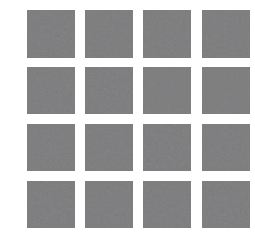

In [72]:
# Callback
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  n = int(np.sqrt(num_examples_to_generate))
  fig = plt.figure(figsize=(n,n))
  for i in range(predictions.shape[0]):
      plt.subplot(n, n, i+1)
      if num_colors == 1:
         plt.imshow(predictions[i, :, :, 0], cmap='gray')
      else:
         plt.imshow(predictions[i, :, :, :])
      plt.axis('off')
  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  

# Test 
generate_and_save_images(model, 0, random_vector_for_generation)  

Epoch: 2, Test set ELBO: -1833.40576171875, time elapse for current epoch 24.706092834472656


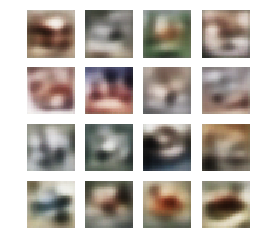

In [73]:
# Training loop
epoch_start = 1
epochs = 2
optimizer = tf.keras.optimizers.Adam(1e-3)

for epoch in range(epoch_start+1, epoch_start + epochs):
  start_time = time.time()
  for batch in train_dataset:
    train_x, train_y = batch
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for batch in test_dataset:
      test_x, test_y = batch
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

# Post-training

### Display images generated during training

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
plt.imshow(display_image(epochs))
plt.axis('off')